In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats

In [2]:
data = pd.read_csv('FinalData_400.csv')
data.head()

,# Label,Subject,Ac_Hor,Ac_Ver,Gy_Hor,Gy_Ver
0,1.0,150.0,0.279718,0.392480,2.563478,10.166052
1,1.0,150.0,0.301232,0.363047,2.001541,9.908323
2,1.0,150.0,0.306589,0.308955,1.446601,9.649285
3,1.0,150.0,0.293114,0.234033,0.980157,9.431819
4,1.0,150.0,0.264363,0.145865,0.745235,9.287633


In [3]:
final_data = data.rename(columns = {'# Label':'act',' Subject':'subject',' Ac_Hor':'ah',
                                    ' Ac_Ver':'av',' Gy_Hor':'gh',' Gy_Ver':'gv'}).copy()
# final_data.head()

In [4]:
label = LabelEncoder()                       # labelling the float type label to integers

final_data['label'] = label.fit_transform(final_data['act'])
final_data.head()

,act,subject,ah,av,gh,gv,label
0,1.0,150.0,0.279718,0.392480,2.563478,10.166052,0
1,1.0,150.0,0.301232,0.363047,2.001541,9.908323,0
2,1.0,150.0,0.306589,0.308955,1.446601,9.649285,0
3,1.0,150.0,0.293114,0.234033,0.980157,9.431819,0
4,1.0,150.0,0.264363,0.145865,0.745235,9.287633,0


In [5]:
final_data['ah'] = final_data['ah'].astype(float)         # convert the data to float
final_data['av'] = final_data['av'].astype(float)
final_data['gh'] = final_data['gh'].astype(float)
final_data['gv'] = final_data['gv'].astype(float)

In [6]:
# final_data['label'].value_counts()   
# final_data['act'].value_counts()......................checking for the equivalence of classes and labels

In [7]:
normal = final_data[final_data['act']== 1.0].head(38838).copy()                # Balancing the Dataset  
downstairs = final_data[final_data['act']== 3.0].head(38838).copy()
upstairs = final_data[final_data['act']== 2.0].head(38838).copy()

In [8]:
bal_data = pd.DataFrame()                            
bal_data = bal_data.append([normal, upstairs, downstairs])
bal_data.shape
#bal_data.head(100)

(116514, 7)

In [9]:
balanced_data = bal_data.drop(['act','subject'],axis = 1).copy()   # dropping the unwanted act and subject column
# balanced_data.head()

## Feature Scaling (Gaussian distribution)

In [10]:
x = balanced_data[['ah', 'av', 'gh', 'gv']]       
y = balanced_data['label']

scaler = StandardScaler()
X = scaler.fit_transform(x)                     

scaled_X = pd.DataFrame(data = X, columns=['ah', 'av', 'gh', 'gv'])
scaled_X['label'] = y.values

scaled_X

,ah,av,gh,gv,label
0,-0.995209,0.432833,-0.247525,1.314444,0
1,-0.967546,0.398880,-0.517510,1.287312,0
2,-0.960659,0.336482,-0.784134,1.260042,0
3,-0.977985,0.250055,-1.008238,1.237148,0
4,-1.014953,0.148348,-1.121108,1.221969,0
...,...,...,...,...,...
116509,-0.782146,0.207688,0.493480,-1.051853,2
116510,-0.734403,0.030417,0.236320,-1.130870,2
116511,-0.754751,-0.128896,-0.015912,-1.191761,2
116512,-0.843471,-0.252373,-0.227429,-1.229987,2


## Extracting frames of 4 seconds

In [11]:
sampling_frequency = 50
frame_size = sampling_frequency*4
jump_size = sampling_frequency*2

def extract_frames(data, frame_size, jump_size):

    feature_shape = 4

    frames = []
    labels = []
    for i in range(0, len(data) - frame_size, jump_size):
        x1 = data['ah'].values[i: i + frame_size]
        y1 = data['av'].values[i: i + frame_size]
        x2 = data['gh'].values[i: i + frame_size]
        y2 = data['gv'].values[i: i + frame_size]
      
        
        # Retrieve the most often used label in this segment
        label = stats.mode(data['label'][i: i + frame_size])[0][0]
        frames.append([x1, y1, x2, y2])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, feature_shape)
    labels = np.asarray(labels)

    return frames, labels

## Preparing the training and testing dataset

In [12]:
X, y = extract_frames(scaled_X, frame_size, jump_size)
X.shape, y.shape

((1164, 200, 4), (1164,))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0, stratify = y)
X_train.shape, X_test.shape

((931, 200, 4), (233, 200, 4))

## Model Architecture

model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=X_train[0].shape))                

model.add(keras.layers.Dense(500, activation="relu",kernel_regularizer=keras.regularizers.l1(0.001)))
keras.layers.Dropout(rate=0.4)
model.add(keras.layers.Dense(300, activation="relu",kernel_regularizer=keras.regularizers.l1(0.001)))
keras.layers.Dropout(rate=0.4)
model.add(keras.layers.Dense(100, activation="relu",kernel_regularizer=keras.regularizers.l1(0.01)))

model.add(keras.layers.Dense(3, activation="softmax"))


In [29]:
from tensorflow.keras.models import model_from_json
with open('model.json','r') as file:
    model_json = file.read()
    
loaded_model = model_from_json(model_json)                            # Loading the model architecture

In [30]:
loaded_model.load_weights('weights.h5')                               # loading the pretrained weights

In [25]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_4 (Dense)             (None, 500)               400500    
                                                                 
 dense_5 (Dense)             (None, 300)               150300    
                                                                 
 dense_6 (Dense)             (None, 100)               30100     
                                                                 
 dense_7 (Dense)             (None, 3)                 303       
                                                                 
Total params: 581,203
Trainable params: 581,203
Non-trainable params: 0
_________________________________________________________________


## Evaluating predictions using Confusion Matrix

In [26]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools

In [31]:
predictions = loaded_model.predict(X_test)

In [32]:
rounded_predictions = np.argmax(predictions, axis = -1)

In [33]:
cm = confusion_matrix(y_true = y_test, y_pred = rounded_predictions)

In [34]:
def plot_confusion_matrix(cm, classes, normalize=False,title = 'Confusion Matrix', cmap = plt.cm.Blues):
    plt.imshow(cm, cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis = 1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix without normalization')
        
    print(cm)
    
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0],range(cm.shape[1]))):
        plt.text(j,i,cm[i,j],
                horizontalalignment = "center",
                color = "white" if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted label')

Confusion Matrix without normalization
[[52 11 15]
 [ 8 60 10]
 [13  7 57]]


TypeError: 'range' object cannot be interpreted as an integer

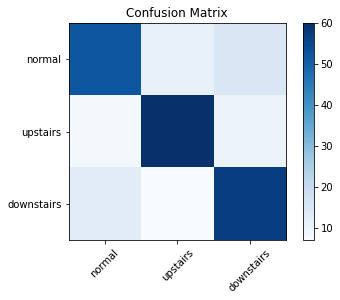

In [35]:
cm_plot_labels = ['normal', 'upstairs', 'downstairs']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,title='Confusion Matrix')

## K-fold Cross Validation (2,5,10)

In [14]:
def buil_ANN():
    from tensorflow.keras.models import model_from_json
    with open('model.json','r') as file:
        model_json = file.read()
    
    loaded_model = model_from_json(model_json)
    loaded_model.load_weights('weights.h5')
    loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
    
    return loaded_model

In [15]:
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

###  5-fold

In [16]:
model = KerasClassifier(build_fn = buil_ANN , epochs = 30)
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, scoring = None, cv = 5)

C:\Users\ratho\AppData\Local\Temp/ipykernel_4884/3900195043.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn = buil_ANN , epochs = 30)


Epoch 1/30
24/24 [==============================] - 1s 7ms/step - loss: 14.8237 - accuracy: 0.9449
Epoch 2/30
24/24 [==============================] - 0s 7ms/step - loss: 14.6832 - accuracy: 0.9516
Epoch 3/30
24/24 [==============================] - 0s 7ms/step - loss: 14.5572 - accuracy: 0.9543
Epoch 4/30
24/24 [==============================] - 0s 6ms/step - loss: 14.4287 - accuracy: 0.9530
Epoch 5/30
24/24 [==============================] - 0s 6ms/step - loss: 14.3025 - accuracy: 0.9583
Epoch 6/30
24/24 [==============================] - 0s 6ms/step - loss: 14.1769 - accuracy: 0.9530
Epoch 7/30
24/24 [==============================] - 0s 6ms/step - loss: 14.0532 - accuracy: 0.9597
Epoch 8/30
24/24 [==============================] - 0s 6ms/step - loss: 13.9349 - accuracy: 0.9556
Epoch 9/30
24/24 [==============================] - 0s 6ms/step - loss: 13.8127 - accuracy: 0.9624
Epoch 10/30
24/24 [==============================] - 0s 7ms/step - loss: 13.6974 - accuracy: 0.9583
Epoch 11/

In [18]:
accuracies.mean()

0.8656949043273926

### 2-fold

In [19]:
model = KerasClassifier(build_fn = buil_ANN , epochs = 30)
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, scoring = None, cv = 2)

C:\Users\ratho\AppData\Local\Temp/ipykernel_4884/4088143087.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn = buil_ANN , epochs = 30)


Epoch 1/30
15/15 [==============================] - 0s 7ms/step - loss: 14.8296 - accuracy: 0.9505
Epoch 2/30
15/15 [==============================] - 0s 7ms/step - loss: 14.7364 - accuracy: 0.9634
Epoch 3/30
15/15 [==============================] - 0s 7ms/step - loss: 14.6460 - accuracy: 0.9634
Epoch 4/30
15/15 [==============================] - 0s 7ms/step - loss: 14.5630 - accuracy: 0.9634
Epoch 5/30
15/15 [==============================] - 0s 7ms/step - loss: 14.4787 - accuracy: 0.9634
Epoch 6/30
15/15 [==============================] - 0s 7ms/step - loss: 14.3952 - accuracy: 0.9699
Epoch 7/30
15/15 [==============================] - 0s 7ms/step - loss: 14.3130 - accuracy: 0.9634
Epoch 8/30
15/15 [==============================] - 0s 7ms/step - loss: 14.2370 - accuracy: 0.9634
Epoch 9/30
15/15 [==============================] - 0s 7ms/step - loss: 14.1549 - accuracy: 0.9720
Epoch 10/30
15/15 [==============================] - 0s 7ms/step - loss: 14.0788 - accuracy: 0.9742
Epoch 11/

In [20]:
accuracies.mean()

0.8667958974838257

### 10-fold

In [21]:
model = KerasClassifier(build_fn = buil_ANN , epochs = 30)
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, scoring = None, cv = 10)

C:\Users\ratho\AppData\Local\Temp/ipykernel_4884/2249541682.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn = buil_ANN , epochs = 30)


Epoch 1/30
27/27 [==============================] - 1s 7ms/step - loss: 14.8074 - accuracy: 0.9474
Epoch 2/30
27/27 [==============================] - 0s 7ms/step - loss: 14.6566 - accuracy: 0.9522
Epoch 3/30
27/27 [==============================] - 0s 7ms/step - loss: 14.5182 - accuracy: 0.9498
Epoch 4/30
27/27 [==============================] - 0s 7ms/step - loss: 14.3812 - accuracy: 0.9355
Epoch 5/30
27/27 [==============================] - 0s 7ms/step - loss: 14.2398 - accuracy: 0.9546
Epoch 6/30
27/27 [==============================] - 0s 7ms/step - loss: 14.0947 - accuracy: 0.9558
Epoch 7/30
27/27 [==============================] - 0s 7ms/step - loss: 13.9650 - accuracy: 0.9594
Epoch 8/30
27/27 [==============================] - 0s 7ms/step - loss: 13.8284 - accuracy: 0.9582
Epoch 9/30
27/27 [==============================] - 0s 7ms/step - loss: 13.6985 - accuracy: 0.9606
Epoch 10/30
27/27 [==============================] - 0s 7ms/step - loss: 13.5624 - accuracy: 0.9630
Epoch 11/

In [22]:
accuracies.mean()

0.8764127194881439